In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy import signal
from numpy.fft import fft
import librosa, librosa.display
import soundfile as sf
import IPython.display as ipd

# Prova de conceito p/ TCC
### Espectrograma de modulação em frequência
### Miguel de Sousa, Universidade Federal do Rio de Janeiro, Abril/2021

### Referências:
- Exploitation of Spectral Redundancy in Cyclostationary Signals (1991), Gardner.
- A Scalable and Progressive Audio Codec (2001), Atlas.
- Joint Acoustic and Modulation Frequency (2003), Atlas.
- Feasability of single channel speaker separation on modulation frequency analysis (2007), Schimmel & Atlas.
- Amplitude Modulation Spectrogram based features for robust speech recognition in noisy and reverberant environments (2011), Moritz.
- Fundamentals of Music Processing: Audio, Analysis, Algorithms, Applications (2016), Muller.


In [2]:
from librosa import stft
from numpy import conjugate, zeros_like

def plot_signal(signal, t, F_coef, x_view_max_t, x_view_max_fft, suptitle, letter, x_view_min_fft=0):
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'${letter}[t]$')
    plt.xlabel('t (seconds)')
    plt.axis(xmin=0, xmax=x_view_max_t)
    plt.plot(t, signal)
    plt.subplot(1, 2, 2)
    plt.title(f'$|{letter.upper()}[k]|$')
    plt.xlabel('$F_{coef}$ $[k]$ (Hz)')
    plt.plot(F_coef, abs(fft(signal)))
    plt.axis(xmin=x_view_min_fft, xmax=x_view_max_fft)
    plt.suptitle(suptitle)
    
def plot_stft(signal, fs, title, max_y = None, n_fft = 2048):
    D = librosa.stft(signal, n_fft = n_fft)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr = fs)
    ax.set(title=title)
    if max_y is not None:
        ax.set_ylim(0,max_y)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    
def plot_mod_specgram(signal, fs, title):
    D, _, _ = get_mod_specgram(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr = fs)
    ax.set(title=title)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    
def stft_basic(x, w, Fs, H=8, only_positive_frequencies=False):
    """From muller FMP Notebooks. Compute a basic version of the discrete short-time Fourier transform (STFT)

    Notebook: C2/C2_STFT-Basic.ipynb

    Args:
        x (np.ndarray): Signal to be transformed
        w (np.ndarray): Window function
        H (int): Hopsize (Default value = 8)
        only_positive_frequencies (bool): Return only positive frequency part of spectrum (non-invertible)
            (Default value = False)

    Returns:
        X (np.ndarray): The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
        
    F_coef = np.arange(X.shape[0]) * Fs / N
    # print(F_coef)
    T_coef = np.arange(X.shape[1]) * H / Fs
    # print(T_coef)
    return (X, F_coef, T_coef)

def get_mod_specgram(x, w, Fs, H=8, only_positive_frequencies=False, max_mod=None) -> np.ndarray:
    """generate a modulation spectrogram, like Atlas(2003)"""
    D, _, _ = stft_basic(x, w, Fs, H)
    # print(f'D.shape = {D.shape}')
    N = len(D[1])
    g = np.ones(N)
    X = np.zeros((D.shape[0], N), dtype='complex')
    # print(X.shape)
    # print(X.shape)
    # print(f'X.shape = {X.shape}')
    for m in range(X.shape[0]):
        x_win = np.abs(D[m]) * g
        X_win = np.fft.fft(x_win)
        X[m] = X_win
    
    if only_positive_frequencies:
        K = 1 + D.shape[0] // 2
        X = X[0:K, :]
        
    if max_mod is not None:
        X = X[:, 0:max_mod]
           
    F_coef = np.arange(D.shape[0]) * Fs / len(w)
#    Mod_coef = np.arange(X.shape[1]) * Fs / len(g)
    Mod_coef = np.arange(X.shape[1]) * len(g) / Fs

    if only_positive_frequencies:
        V = 1 + D.shape[1] // 2
        Mod_coef = Mod_coef[0:V]
        X = X[:, 0:V]
    return (X, F_coef, Mod_coef)

def plot_content(suptitle,x,t,Y,boundaries, is_mod=False):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(t)), x, c='k')
    plt.xlim([0, len(t)])
    plt.xlabel('Index (samples)')
    plt.subplot(1, 2, 2)
    plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r')
    plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r',extent=boundaries)
    plt.ylabel('Index (frequency) -> Hz')
    plt.suptitle(suptitle)
    if is_mod:
        plt.xlabel('Index (frequency) -> Hz')
        return;
    plt.xlabel('Index (frames) -> seconds')

def get_stft_boundaries(F_coef, T_coef, N, Fs):
    left = min(T_coef)
    right = max(T_coef) + N / Fs
    lower = min(F_coef)
    upper = max(F_coef)
    return [left, right, lower, upper]

def get_mod_boundaries(F_coef, Mod_coef, g, Fs):
    left = min(Mod_coef)
    #right = max(Mod_coef) + len(g) / Fs
    right = max(Mod_coef)
    lower = min(F_coef)
    upper = max(F_coef)
    return [left, right, lower, upper]

def get_row_indexes_with_most_energy(matrix, factor = 2) :
    energies = [ np.mean(np.abs(matrix[i])) for i in range(matrix.shape[0]) ]
    return [ i for i in range(len(energies)) if energies[i] > np.max(energies) / factor]

def block_plot(x, t, Fs, w, H, title1 = 'stft', title2 = 'mod spec', only_positive_frequencies=True):
    X, F_coef, T_coef = stft_basic(x, w, Fs, H, only_positive_frequencies)
    ModX, _, Mod_coef = get_mod_specgram(x, w, Fs, H, only_positive_frequencies)
    #print(f'mod_coef = {Mod_coef}')
    plot_content(title1, x,t,np.abs(X) ** 2, get_stft_boundaries(F_coef, T_coef, N, Fs))
    plot_content(title2, x,t,np.abs(ModX) ** (1. / 3), get_mod_boundaries(F_coef, Mod_coef, X[1], Fs), is_mod=True)
    return ModX, X

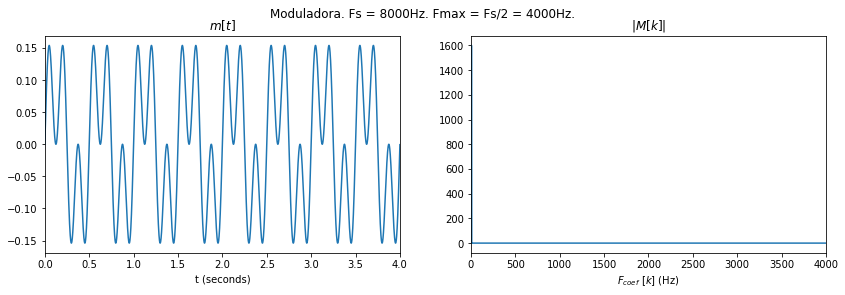

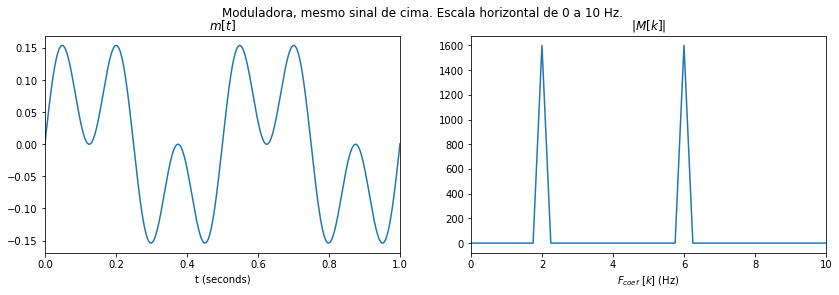

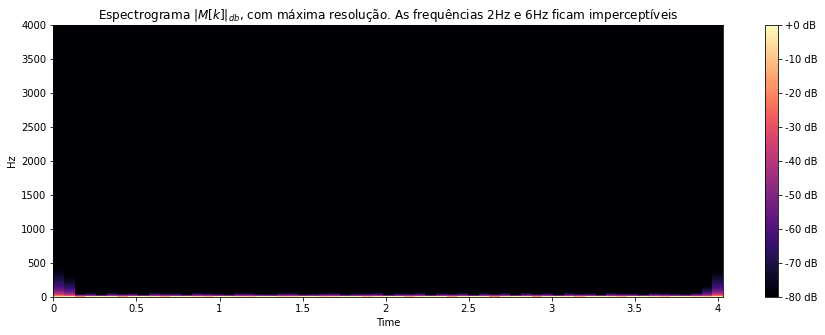

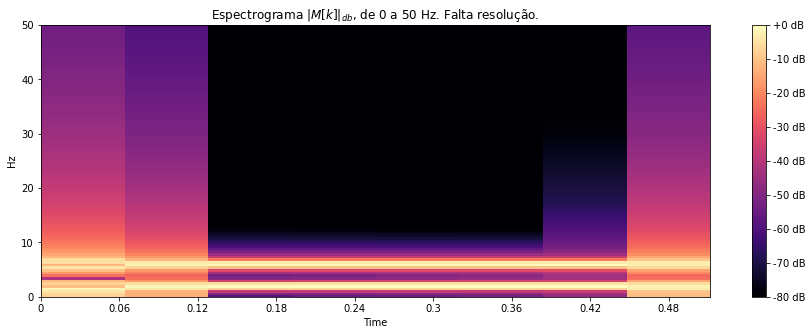

In [3]:
fs = 8000
# N = 2 * 4*fs
N = 4*fs
modFreq = 2
carrFreq = 800
t = np.arange(N) / fs

modulator = 0.1 * (np.sin(2*np.pi*modFreq*t) + np.sin(2*np.pi*3*modFreq*t))
modulator_fft = abs(fft(modulator))
M_coef = np.arange(modulator_fft.shape[0]) * fs / (N)
plot_signal(modulator, t, M_coef, 4, 4000, 'Moduladora. Fs = 8000Hz. Fmax = Fs/2 = 4000Hz.', 'm')
plot_signal(modulator, t, M_coef, 1, 10, 'Moduladora, mesmo sinal de cima. Escala horizontal de 0 a 10 Hz.', 'm')
plot_stft(modulator, fs, 'Espectrograma $|M[k]|_{db}$, com máxima resolução. As frequências 2Hz e 6Hz ficam imperceptíveis')
plot_stft(modulator, fs, 'Espectrograma $|M[k]|_{db}$, de 0 a 50 Hz. Falta resolução.', max_y = 50, n_fft = 4096 * 4)

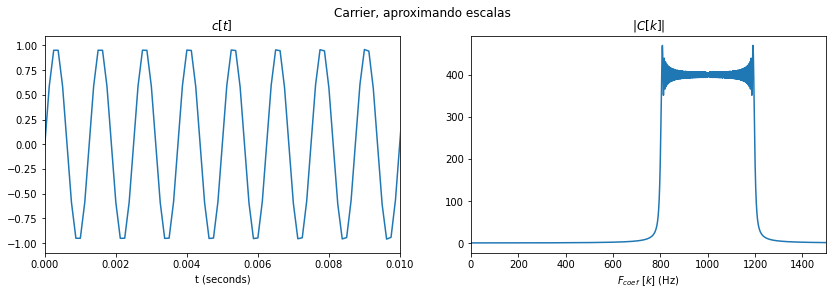

In [4]:
carrier = np.sin(2*np.pi*(carrFreq*t + 50*np.square(t)))
carrier_fft = abs(fft(carrier))
C_coef = np.arange(carrier_fft.shape[0]) * fs / (N)
plot_signal(carrier, t, C_coef, 0.1, 4000, 'Carrier', 'c')
plot_signal(carrier, t, C_coef, 0.01, 1500, 'Carrier, aproximando escalas', 'c')

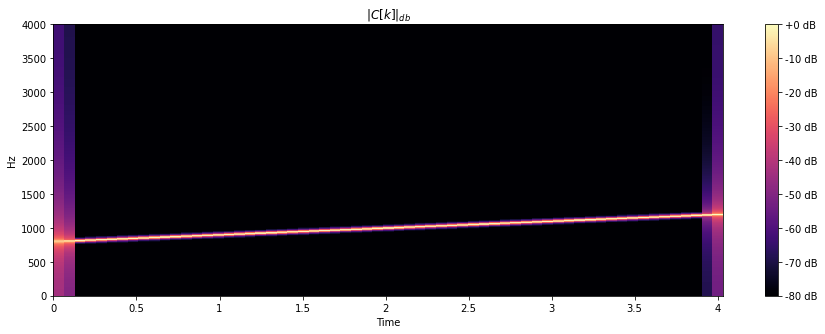

In [5]:
plot_stft(carrier, fs, '$|C[k]|_{db}$')

In [6]:
plot_stft(carrier, fs, '$|C[k]|_{db}$', max_y = 1500, n_fft = 4096 * 4)

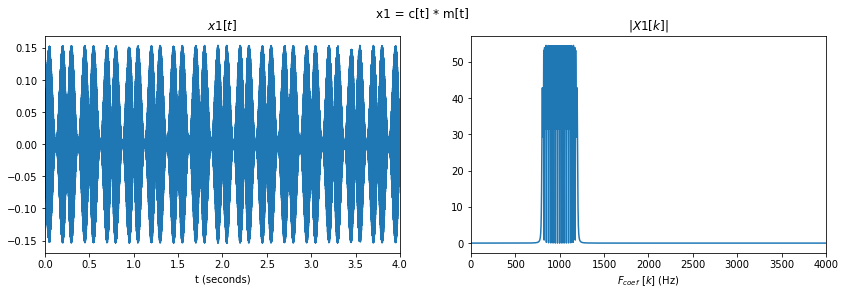

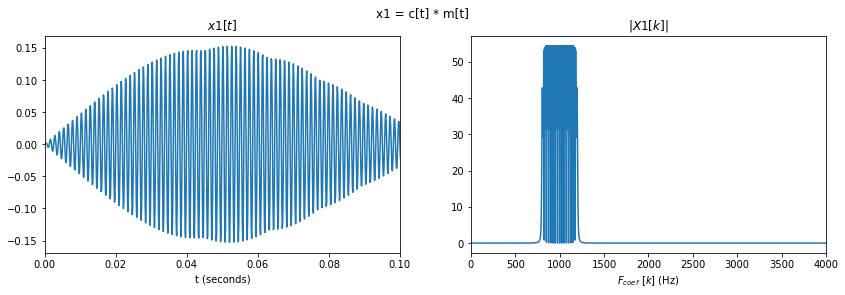

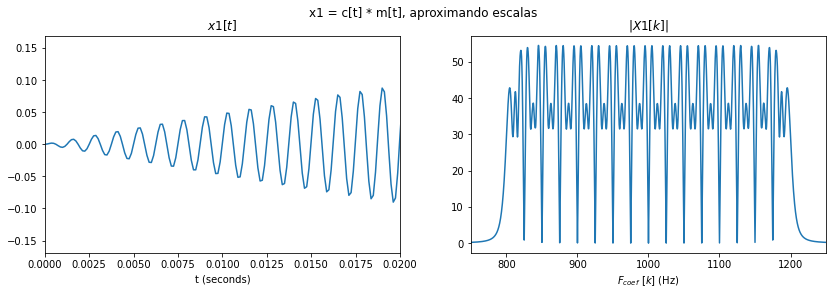

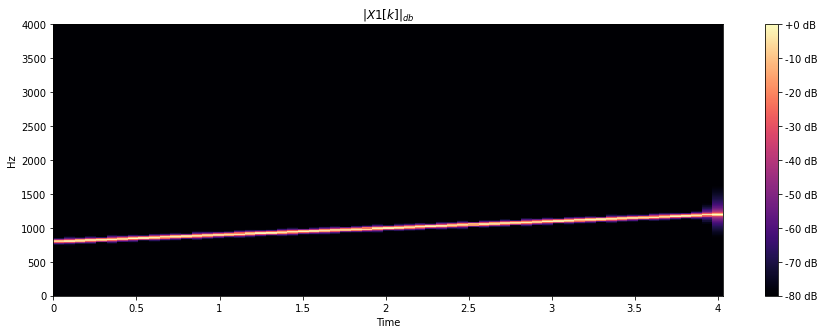

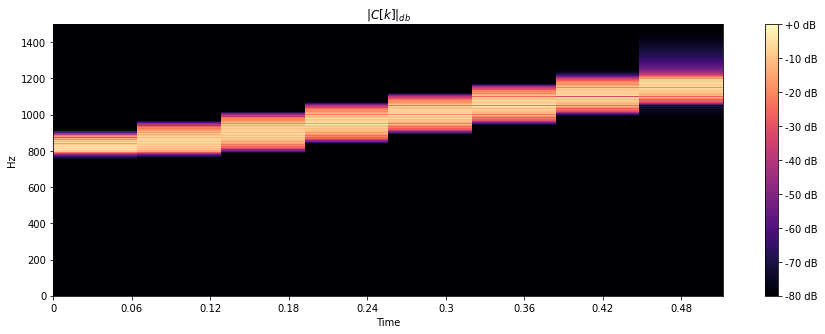

In [7]:
x1 = np.multiply(modulator, carrier)
X1 = abs(fft(x1))
X1_coef = np.arange(X1.shape[0]) * fs / (N)
plot_signal(x1, t, X1_coef, 4, 4000, 'x1 = c[t] * m[t]', 'x1')
plot_signal(x1, t, X1_coef, 0.1, 4000, 'x1 = c[t] * m[t]', 'x1')
plot_signal(x1, t, X1_coef, 0.02, 1250, 'x1 = c[t] * m[t], aproximando escalas', 'x1', x_view_min_fft=750)

plot_stft(x1, fs, '$|X1[k]|_{db}$')
plot_stft(x1, fs, '$|C[k]|_{db}$', max_y = 1500, n_fft = 4096 * 4)

# Com base na implementação do Muller:

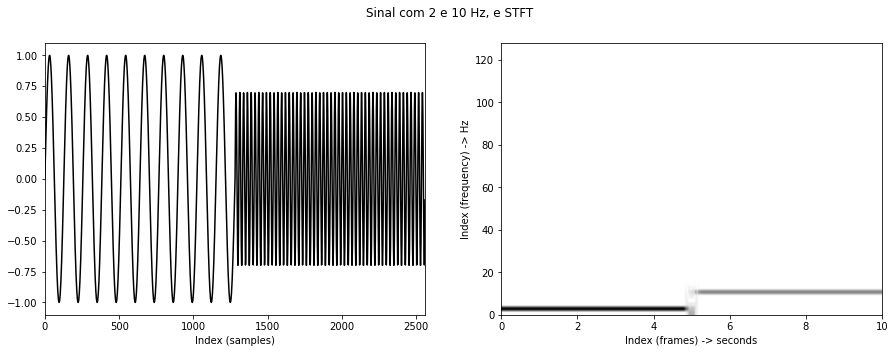

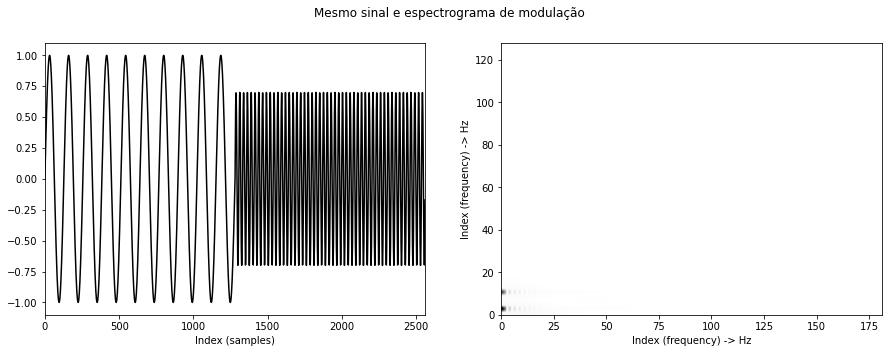

In [8]:
Fs = 256
duration = 10
omega1 = 2
omega2 = 10
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))
 
H = 8
N = 128


w = np.ones(N)
X, F_coef, T_coef = stft_basic(x, w, Fs, H, only_positive_frequencies=True)
ModX, _, Mod_coef = get_mod_specgram(x, w, Fs, H, only_positive_frequencies=True)

Y = np.abs(X) ** 2
ModY = np.abs(ModX) ** 1/4

plot_content('Sinal com 2 e 10 Hz, e STFT', x,t,Y,get_stft_boundaries(F_coef, T_coef, N, Fs))
plot_content('Mesmo sinal e espectrograma de modulação',x,t,ModY, get_mod_boundaries(F_coef, Mod_coef, X[1], Fs), is_mod=True)

### O exemplo acima é útil apenas para determinar se as dimensões da transformada estão corretas, assim como os valores informados nos eixos dos gráficos.

In [9]:
get_row_indexes_with_most_energy(ModY, factor = 4)

[1, 5]

Plot das linhas que concentram mais energia:

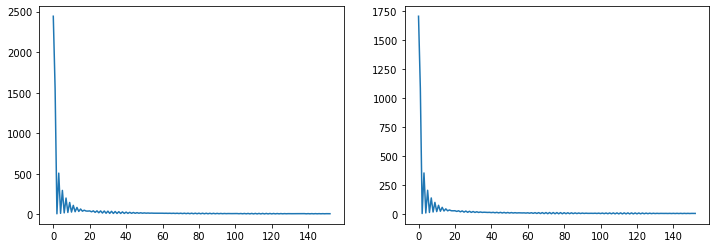

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ModY[1])
plt.subplot(1, 2, 2)
plt.plot(ModY[5])

ex:
Sinal com 200 amostras.
janela de tamanho 10, sem overlap.
STFT terá resolução de 10 frames na frequência, 20 frames no tempo.

ex2:
STFT com 10 frames na frequência, 20 frames no tempo.
Para cada frequência (ou seja, cada linha da matriz), faço uma FFT com os 20 frames no tempo.

Dessa forma, a matriz terá 10 frames das frequências originais da STFT, e 20 frames de modulação de amplitude.

dispensar os frames com as frequências negativas antes de plotar nos gráficos.

t goes from 0.0 to 3.999875


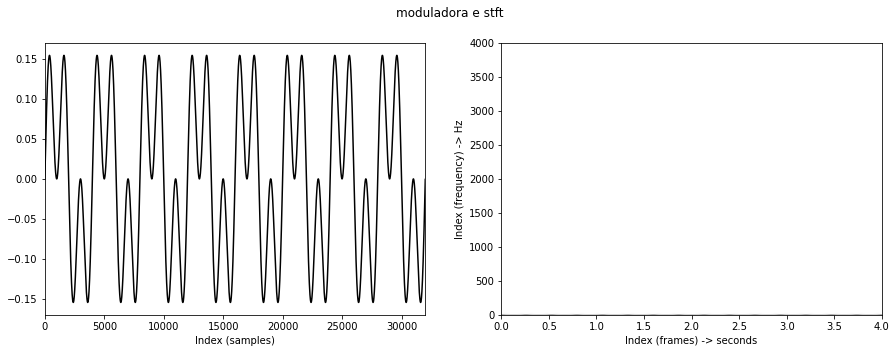

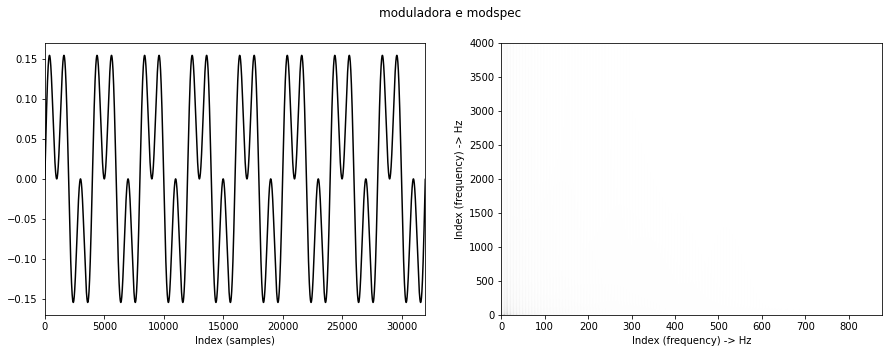

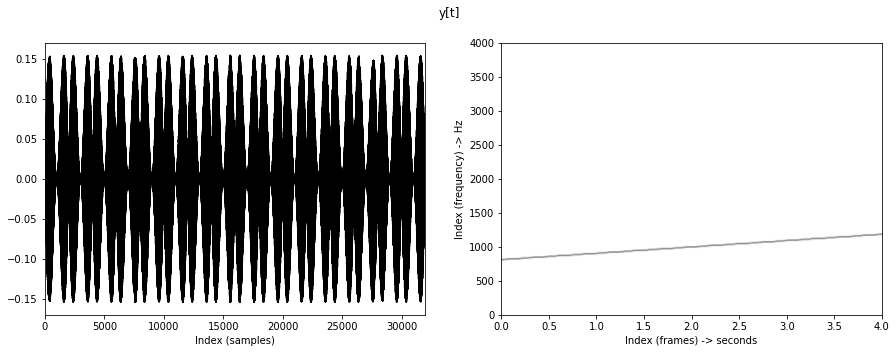

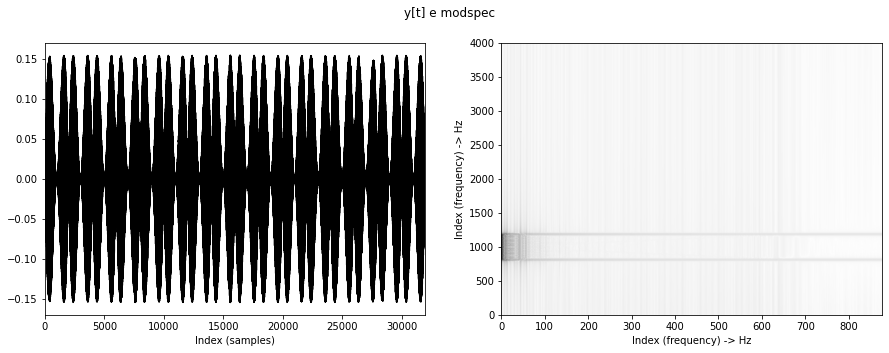

In [11]:
fs = 8000
N = 4*fs
modFreq = 2
carrFreq = 800
t = np.arange(N) / fs
print(f"t goes from {t[0]} to {t[-1]}")

modulator = 0.1 * (np.sin(2*np.pi*modFreq*t) + np.sin(2*np.pi*3*modFreq*t))
carrier = np.sin(2*np.pi*(carrFreq*t + 50*np.square(t)))
x1 = np.multiply(modulator, carrier)

H = 8
N = 2048
w = np.ones(N)

_ = block_plot(modulator, t, fs, w, H, 'moduladora e stft', 'moduladora e modspec')
_ = block_plot(carrier, t, fs, w, H, 'y[t] = c[t] . m[t]', 'y[t] e stft')
_ = block_plot(x1, t, fs, w, H, 'y[t]', 'y[t] e modspec')

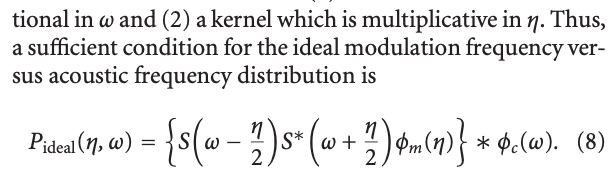

Novo teste.

t goes from 0.0 to 3.9999773242630385. It has len(176400) samples
slice_size = 29400, start = 0, end = 29400
slice_size = 29400, start = 29400, end = 58800
slice_size = 29400, start = 58800, end = 88200
slice_size = 29400, start = 88200, end = 117600
slice_size = 29400, start = 117600, end = 147000
slice_size = 29400, start = 147000, end = 176400


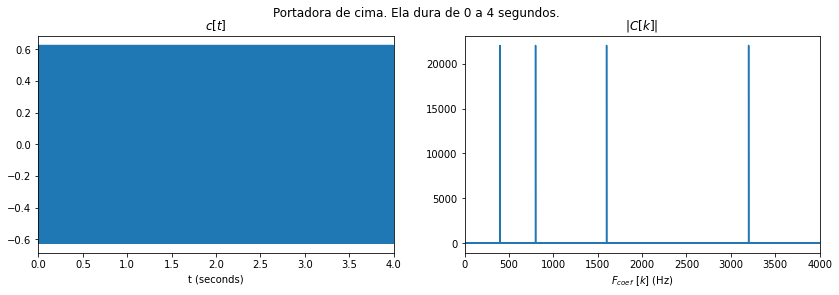

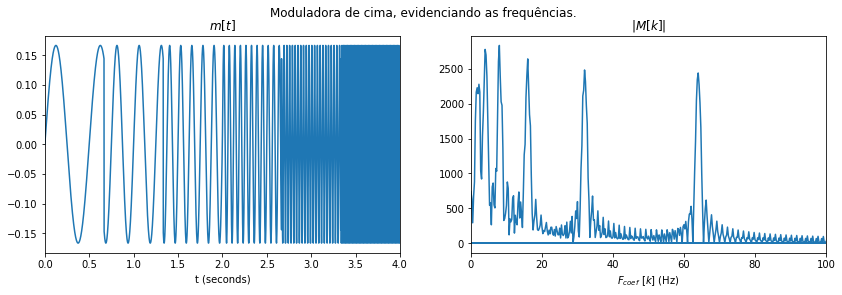

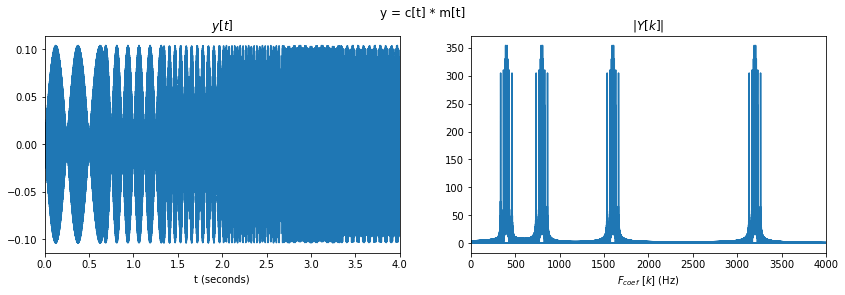

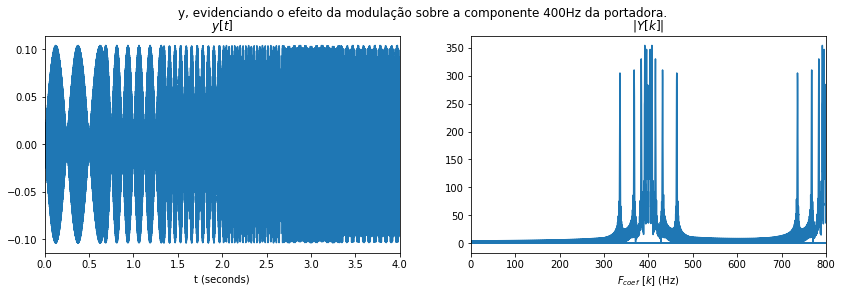

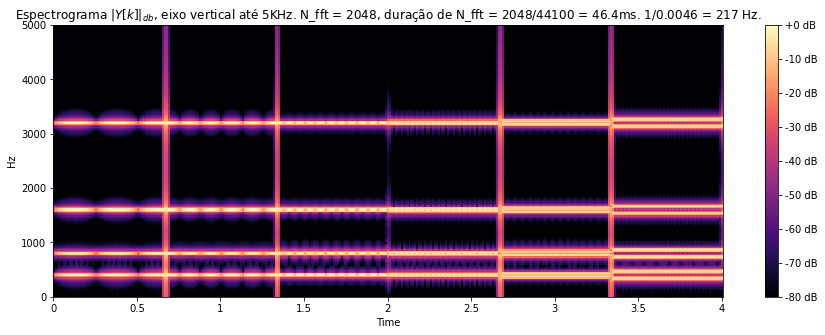

In [12]:
fs = 44100
sample_length = 4*fs
modFreq = [2, 4, 8, 16, 32, 64]
carrFreq = [400, 800, 1600, 3200]
t = np.arange(sample_length) / fs
print(f"t goes from {t[0]} to {t[-1]}. It has len({sample_length}) samples")
carrier = np.zeros(shape=(len(t)))
for frequency in carrFreq:
    carrier = carrier + (1/len(carrFreq)) * np.sin(2*np.pi*frequency*t)
slice_size = int(sample_length/len(modFreq))
modulator = np.zeros(shape=(len(t)))
for index, frequency in enumerate(modFreq):
    start = slice_size * index
    end = slice_size*index + slice_size
    print(f'slice_size = {slice_size}, start = {start}, end = {end}')
    modulator[start:end] = modulator[start:end] + (1/len(modFreq)) * np.sin(2*np.pi*frequency*t[start:end])
signal = carrier * modulator
signal_fft = abs(fft(modulator))
coef = np.arange(signal.shape[0]) * fs / sample_length

plot_signal(carrier, t, coef, 0.01, 4000, 'Portadora com 400Hz e seus 3 primeiros harmônicos.', 'c')
plot_signal(carrier, t, coef, 4, 4000, 'Portadora de cima. Ela dura de 0 a 4 segundos.', 'c')
plot_signal(modulator, t, coef, 4, 4000, 'Moduladora com frequências em 2, 4, 8, 16, 32 e 64Hz.', 'm')
plot_signal(modulator, t, coef, 4, 100, 'Moduladora de cima, evidenciando as frequências.', 'm')
plot_signal(signal, t, coef, 4, 4000, 'y = c[t] * m[t]', 'y')
plot_signal(signal, t, coef, 4,800, 'y, evidenciando o efeito da modulação sobre a componente 400Hz da portadora.', 'y')
plot_stft(signal, fs, 'Espectrograma $|Y[k]|_{db}$, eixo vertical até fs/2. N_fft = 2048, duração de N_fft = 2048/44100 = 46.4ms. 1/0.0046 = 217 Hz.')
plot_stft(signal, fs, 'Espectrograma $|Y[k]|_{db}$, eixo vertical até 5KHz. N_fft = 2048, duração de N_fft = 2048/44100 = 46.4ms. 1/0.0046 = 217 Hz.', max_y = 5000)
plot_stft(signal, fs, 'Espectrograma $|Y[k]|_{db}$, eixo vertical até 5KHz. N_fft = 512.', max_y = 5000, n_fft= 512)

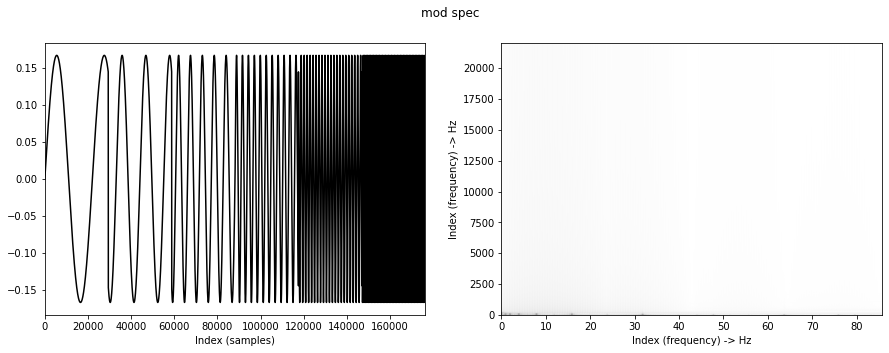

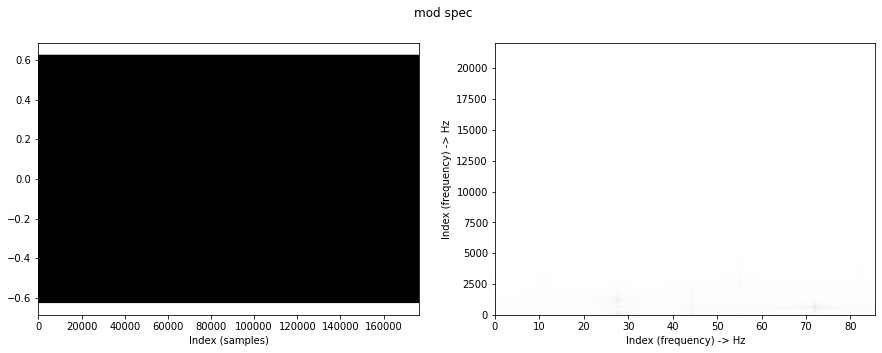

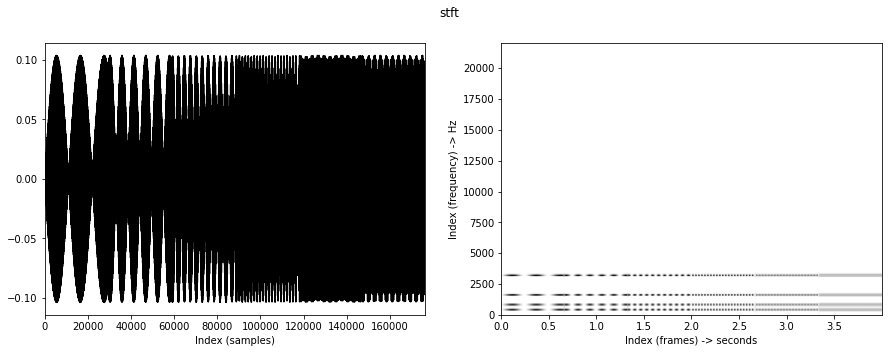

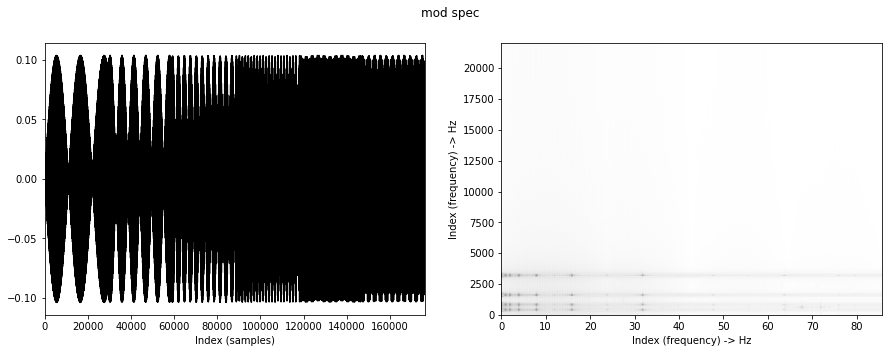

In [13]:
H = 64
N = 512
w = np.hanning(N)

_ = block_plot(modulator,t,fs,w,H)
_ = block_plot(carrier,t,fs,w,H)
ModSignal, Xsignal = block_plot(signal,t,fs,w,H)

In [14]:
print(f'high energy stft bins: {get_row_indexes_with_most_energy(Xsignal)}')
print(f'high energy mod spec bins: {get_row_indexes_with_most_energy(ModSignal)}')

high energy stft bins: [4, 5, 9, 10, 18, 19, 36, 37, 38]
high energy mod spec bins: [4, 5, 9, 10, 18, 19, 37, 38]


In [15]:
def plot_4_graphs(a,a_title, b, b_title, c, c_title, d, d_title):
    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    axs[0, 0].set_title(a_title)
    axs[0, 0].plot(a)
    axs[0, 1].set_title(b_title)
    axs[0, 1].plot(b)
    axs[1, 0].set_title(c_title)
    axs[1, 0].plot(c)
    axs[1, 1].set_title(d_title)
    axs[1, 1].plot(d)
    fig.tight_layout()
    
plot_4_graphs(np.real(Xsignal[18][:]), '18th bin. Real part.',
              np.real(Xsignal[38][:]), '38th bin. Real part.',
              np.imag(Xsignal[18][:]), '18th bin. Imaginary part.',
              np.imag(Xsignal[38][:]), '38th bin. Imaginary part.')

In [16]:
plot_4_graphs(abs(ModSignal[18][:]), '18th bin absolute value.',
              abs(ModSignal[38][:]), '38th bin absolute value.',
              abs(ModSignal[38][1:]), '18th bin absolute value. Without 1st sample.',
              abs(ModSignal[38][1:]), '38th bin absolute value. Without 1st sample.')


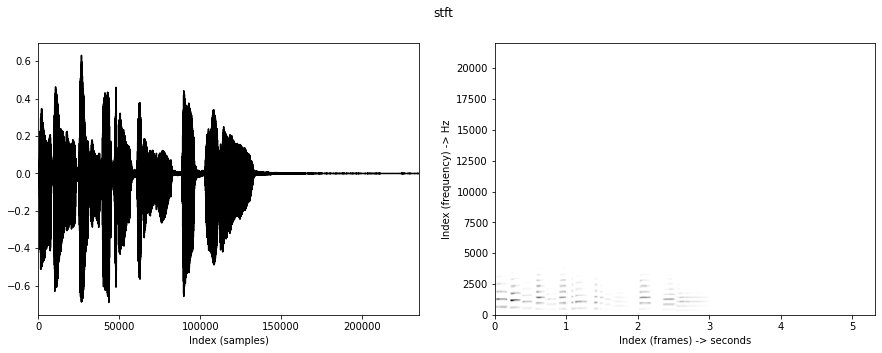

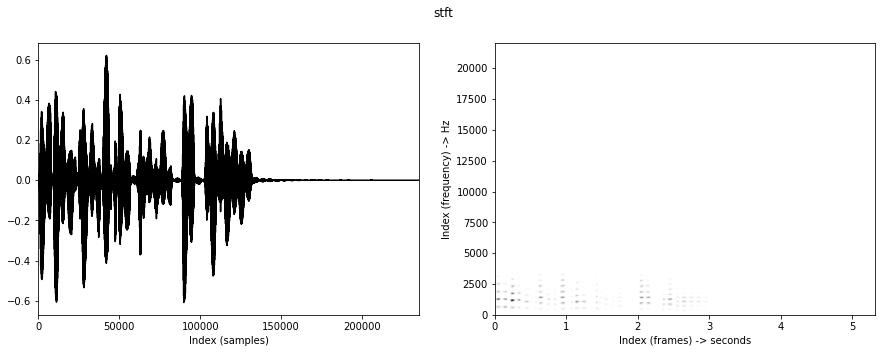

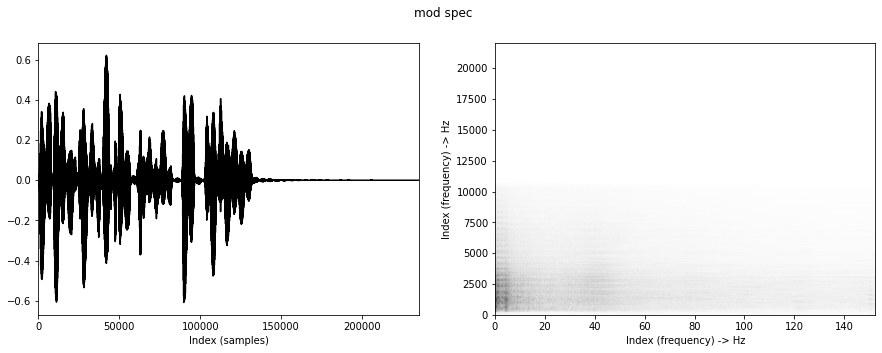

In [21]:
filename = librosa.ex('trumpet')
data, fs_origin = sf.read(filename, dtype='float32')
data = data.T
fs = 44100
data = librosa.resample(data,fs_origin, fs)
t = np.arange(len(data)) / fs
H = 64
N = 128
modulated_data = data * (np.sin(2*np.pi*5*t))
ipd.display(ipd.Audio(data, rate=fs))
ipd.display(ipd.Audio(modulated_data, rate=fs))
_ = block_plot(data,t,fs,w,H)
_ = block_plot(modulated_data,t,fs,w,H)

In [29]:
(np.max(data)+0.1)

1.09

In [36]:
data, sr = sf.read('samples/leslie.wav')
data = (data[:,0] + data[:,1]) / 2

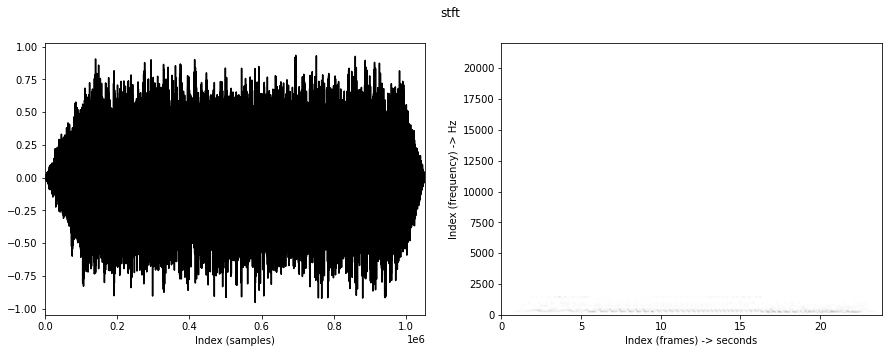

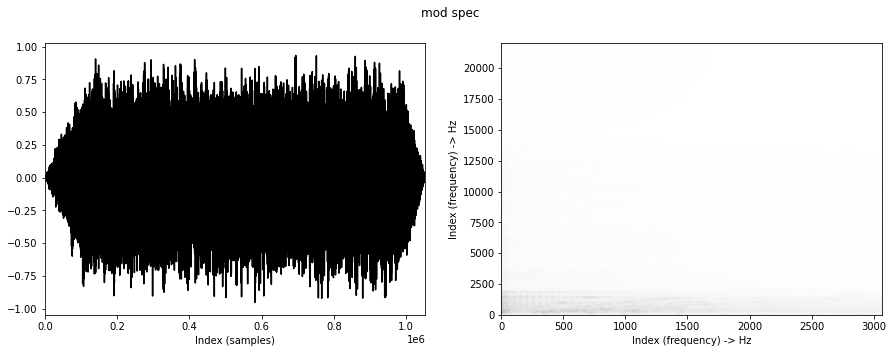

In [40]:
data, sr = sf.read('samples/leslie.wav')
data = (data[:,0] + data[:,1]) / 2
t = np.arange(len(data)) / fs
H = 64
N = 128
ipd.display(ipd.Audio(data, rate=fs))
_ = block_plot(data,t,fs,w,H)

Rascunho:

In [ ]:
# old
# Eu tentei fazer um tensor, sem querer o_o
#     D_conj = conjugate(D)
#     P = zeros_like(D)
#     ETA, OMEGA = P.shape
#     max_row, max_column = D.shape
#     for column in range(0, max_column):
#         for eta in range(0, ETA):
#             for omega in range(0, OMEGA):
#                 if omega - eta / 2 > 0 and omega + eta / 2 < max_row:
#                     P[eta, omega] = P[eta, omega] + D[round(omega - eta / 2), column] * D_conj[round(omega + eta / 2), column]
#     return P